# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [2]:
# Run some setup code for this notebook.

import random
import numpy as np
import matplotlib.pyplot as plt
from cs231n.data_utils import load_CIFAR10

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000L, 32L, 32L, 3L)
Training labels shape:  (50000L,)
Test data shape:  (10000L, 32L, 32L, 3L)
Test labels shape:  (10000L,)


 y: 0
cls: plane
idx.shape: [   29    30    35 ... 49941 49992 49994]
idx.shape: [42908  9077  2578 12910 49371 21522 41600]
y: 1
cls: car
idx.shape: [    4     5    32 ... 49993 49998 49999]
idx.shape: [24620 37153 29874 25150  3379 30269 22335]
y: 2
cls: bird
idx.shape: [    6    13    18 ... 49987 49991 49995]
idx.shape: [ 9603 12148  7279 25125 44995  2927 25302]
y: 3
cls: cat
idx.shape: [    9    17    21 ... 49979 49982 49983]
idx.shape: [25138 31081 40973 14938 35582 15444 15799]
y: 4
cls: deer
idx.shape: [    3    10    20 ... 49981 49984 49990]
idx.shape: [38930 37923 34793 24421 37028 26584 43486]
y: 5
cls: dog
idx.shape: [   27    40    51 ... 49964 49980 49988]
idx.shape: [18064 16771 22305 45469 22021 12235 35052]
y: 6
cls: frog
idx.shape: [    0    19    22 ... 49962 49966 49996]
idx.shape: [27595 18682 24475 43577  5419 20535 17191]
y: 7
cls: horse
idx.shape: [    7    11    12 ... 49965 49978 49986]
idx.shape: [25848 24599 28936  5737 19159 15157 42909]
y: 8
cls: ship
i

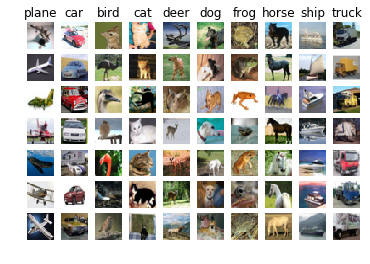

In [6]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [7]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print X_train.shape, X_test.shape

(5000L, 3072L) (500L, 3072L)


In [8]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [9]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_no_loops(X_test)
print dists.shape

(500L, 5000L)
[[41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 ...
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]]
(500L, 5000L)
[[8.39450100e+07 1.06203359e+08 1.18660523e+08 ... 9.51065230e+07
  1.18490720e+08 7.19991020e+07]
 [1.34038391e+08 1.56296740e+08 1.68753904e+08 ... 1.45199904e+08
  1.68584101e+08 1.22092483e+08]
 [1.08356268e+08 1.30614617e+08 1.43071781e+08 ... 1.19517781e+08
  1.42901978e+08 9.64103600e+07]
 ...
 [1.17083045e+08 1.39341394e+08 1.51798558e+08 ... 1.28244558e+08
  1.51628755e+08 1.05137137e+08]
 [8.81482360e+07 1.10406585e+08 1.22863749e+08 ... 9.93097490e+07
  1.22693946e+08 7.62023280e+07]
 [1.76330797e+08 1.98589146e+08 2.11046310e+08 ... 1.87492310e+0

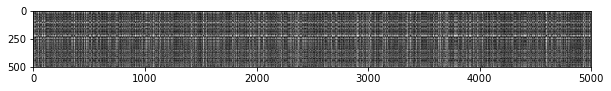

In [10]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

**Your Answer**: *fill this in.*



In [11]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [12]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

In [13]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

Difference was: 0.000000
Good! The distance matrices are the same


In [14]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

(500L, 5000L)
[[41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 ...
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]]
(500L, 5000L)
[[8.39450100e+07 1.06203359e+08 1.18660523e+08 ... 9.51065230e+07
  1.18490720e+08 7.19991020e+07]
 [1.34038391e+08 1.56296740e+08 1.68753904e+08 ... 1.45199904e+08
  1.68584101e+08 1.22092483e+08]
 [1.08356268e+08 1.30614617e+08 1.43071781e+08 ... 1.19517781e+08
  1.42901978e+08 9.64103600e+07]
 ...
 [1.17083045e+08 1.39341394e+08 1.51798558e+08 ... 1.28244558e+08
  1.51628755e+08 1.05137137e+08]
 [8.81482360e+07 1.10406585e+08 1.22863749e+08 ... 9.93097490e+07
  1.22693946e+08 7.62023280e+07]
 [1.76330797e+08 1.98589146e+08 2.11046310e+08 ... 1.87492310e+0

In [15]:
# Let's compare how fast the implementations are
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print 'Two loop version took %f seconds' % two_loop_time

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print 'One loop version took %f seconds' % one_loop_time

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print 'No loop version took %f seconds' % no_loop_time

# you should see significantly faster performance with the fully vectorized implementation

(500L, 3072L)
[[ 59.  62.  63. ... 123.  92.  72.]
 [154. 177. 187. ... 143. 133. 144.]
 [255. 255. 255. ...  80.  86.  84.]
 ...
 [167. 163. 145. ...  42.  78.  84.]
 [154. 152. 125. ... 194. 247. 114.]
 [ 45.  32.  21. ... 156. 142. 100.]]
(500L, 5000L)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
21

### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [16]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
pass
# split self.X_train to 5 folds
avg_size = int(X_train.shape[0] / num_folds) # will abandon the rest if not divided evenly.
for i in range(num_folds):
    X_train_folds.append(X_train[i * avg_size : (i+1) * avg_size])
    y_train_folds.append(y_train[i * avg_size : (i+1) * avg_size])
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
pass
for k in k_choices:
    accuracies = []
    print k
    for i in range(num_folds):
        X_train_cv = np.vstack(X_train_folds[0:i] + X_train_folds[i+1:])
        y_train_cv = np.hstack(y_train_folds[0:i] + y_train_folds[i+1:])
        X_valid_cv = X_train_folds[i]
        y_valid_cv = y_train_folds[i]
        
        classifier.train(X_train_cv, y_train_cv)
        dists = classifier.compute_distances_no_loops(X_valid_cv)
        accuracy = float(np.sum(classifier.predict_labels(dists, k) == y_valid_cv)) / y_valid_cv.shape[0]
        accuracies.append(accuracy)
    k_to_accuracies[k] = accuracies
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print 'k = %d, accuracy = %f' % (k, accuracy)

1
(1000L, 4000L)
[[78898333. 83487101. 31364168. ... 52334313. 75718510. 29226892.]
 [78898333. 83487101. 31364168. ... 52334313. 75718510. 29226892.]
 [78898333. 83487101. 31364168. ... 52334313. 75718510. 29226892.]
 ...
 [78898333. 83487101. 31364168. ... 52334313. 75718510. 29226892.]
 [78898333. 83487101. 31364168. ... 52334313. 75718510. 29226892.]
 [78898333. 83487101. 31364168. ... 52334313. 75718510. 29226892.]]
(1000L, 4000L)
[[1.20071133e+08 1.24659901e+08 7.25369680e+07 ... 9.35071130e+07
  1.16891310e+08 7.03996920e+07]
 [1.42329482e+08 1.46918250e+08 9.47953170e+07 ... 1.15765462e+08
  1.39149659e+08 9.26580410e+07]
 [1.54786646e+08 1.59375414e+08 1.07252481e+08 ... 1.28222626e+08
  1.51606823e+08 1.05115205e+08]
 ...
 [1.14113485e+08 1.18702253e+08 6.65793200e+07 ... 8.75494650e+07
  1.10933662e+08 6.44420440e+07]
 [1.78755477e+08 1.83344245e+08 1.31221312e+08 ... 1.52191457e+08
  1.75575654e+08 1.29084036e+08]
 [1.14732700e+08 1.19321468e+08 6.71985350e+07 ... 8.8168680

(1000L, 4000L)
[[29482297. 22419143. 23580254. ... 16052609. 17746014. 16499358.]
 [23252558. 26521286. 32321101. ... 17144454. 17254437. 32095159.]
 [21634084. 41345678. 39425225. ... 16200666. 24404569. 49250311.]
 ...
 [26780823. 33627509. 18148824. ... 15484699. 21585680. 24249482.]
 [27189561. 41431509. 40933984. ... 29437515. 23410916. 66796444.]
 [28647438. 29278104. 20345573. ... 16534180. 22458291. 20059431.]]
(1000L, 4000L)
[[41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 ...
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]]
(1000L, 4000L)
[[1.20071133e+08 1.42329482e+08 1.54786646e+08 ... 1.31232646e+08
  1.54616843e+08 1.08125225e+08]
 [1.24659901e+08 1.46918250e+08 1.593754

(1000L, 4000L)
[[29482297. 23252558. 21634084. ... 17684260. 17856285. 39597773.]
 [22419143. 26521286. 41345678. ... 29322976. 14067563. 34653647.]
 [23580254. 32321101. 39425225. ... 23771503. 29142518. 29425298.]
 ...
 [15054240. 29523513. 43227289. ... 24452009. 29112080. 11543936.]
 [15779454. 22158345. 49272889. ... 25909289. 18867826. 19898004.]
 [24031482. 17101767. 13186337. ... 13482431. 13735468. 35281280.]]
(1000L, 4000L)
[[41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 ...
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]]
(1000L, 4000L)
[[1.01631161e+08 1.23889510e+08 1.36346674e+08 ... 1.12792674e+08
  1.36176871e+08 8.96852530e+07]
 [8.52084150e+07 1.07466764e+08 1.199239

(1000L, 4000L)
[[23278647. 22468548. 11404136. ...  9874422. 15278815. 36020597.]
 [18450689. 19173190. 40698004. ... 19916622. 26986111. 18359509.]
 [21898096. 20671991. 28711195. ... 17004349. 16900846. 26752122.]
 ...
 [18703397. 27678344. 45528038. ... 26982560. 21180477. 15057243.]
 [16226074. 20514833. 21036295. ... 10134457.  9274724. 25814958.]
 [39290735. 22864854. 21485526. ... 26336456. 20722231. 58077889.]]
(1000L, 4000L)
[[41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 ...
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]]
(1000L, 4000L)
[[1.02104964e+08 1.24363313e+08 1.36820477e+08 ... 1.13266477e+08
  1.36650674e+08 9.01590560e+07]
 [1.24353561e+08 1.46611910e+08 1.590690

(1000L, 4000L)
[[23008044. 27603997. 26295407. ... 16372307. 18796070. 32310108.]
 [29318357. 24417670. 20260332. ... 17703442. 11240429. 38357893.]
 [16449712. 28412131. 41433967. ... 20715543. 26889594. 16324652.]
 ...
 [16545691. 20042810. 20626962. ... 10769070.  7936105. 28463073.]
 [41070876. 34739271.  9253033. ... 16848163. 22468412. 47222934.]
 [19552641. 35520732. 46347212. ... 27843346. 33223915. 12439659.]]
(1000L, 4000L)
[[41172800. 63431149. 75888313. ... 56489999. 79459010. 29156137.]
 [41172800. 63431149. 75888313. ... 56489999. 79459010. 29156137.]
 [41172800. 63431149. 75888313. ... 56489999. 79459010. 29156137.]
 ...
 [41172800. 63431149. 75888313. ... 56489999. 79459010. 29156137.]
 [41172800. 63431149. 75888313. ... 56489999. 79459010. 29156137.]
 [41172800. 63431149. 75888313. ... 56489999. 79459010. 29156137.]]
(1000L, 4000L)
[[1.15053680e+08 1.37312029e+08 1.49769193e+08 ... 1.30370879e+08
  1.53339890e+08 1.03037017e+08]
 [1.35969896e+08 1.58228245e+08 1.706854

(1000L, 4000L)
[[21521912. 17222849. 36944129. ... 20927811. 38108620. 39357851.]
 [28267952. 25070339. 43062177. ... 31642693. 44704514. 42920801.]
 [18688854. 14728685. 28180209. ... 18341503. 28247372. 32303137.]
 ...
 [16052609. 17144454. 16200666. ... 10769070. 16848163. 27843346.]
 [17746014. 17254437. 24404569. ...  7936105. 22468412. 33223915.]
 [16499358. 32095159. 49250311. ... 28463073. 47222934. 12439659.]]
15
(1000L, 4000L)
[[78898333. 83487101. 31364168. ... 52334313. 75718510. 29226892.]
 [78898333. 83487101. 31364168. ... 52334313. 75718510. 29226892.]
 [78898333. 83487101. 31364168. ... 52334313. 75718510. 29226892.]
 ...
 [78898333. 83487101. 31364168. ... 52334313. 75718510. 29226892.]
 [78898333. 83487101. 31364168. ... 52334313. 75718510. 29226892.]
 [78898333. 83487101. 31364168. ... 52334313. 75718510. 29226892.]]
(1000L, 4000L)
[[1.20071133e+08 1.24659901e+08 7.25369680e+07 ... 9.35071130e+07
  1.16891310e+08 7.03996920e+07]
 [1.42329482e+08 1.46918250e+08 9.479

(1000L, 4000L)
[[29482297. 22419143. 23580254. ... 16052609. 17746014. 16499358.]
 [23252558. 26521286. 32321101. ... 17144454. 17254437. 32095159.]
 [21634084. 41345678. 39425225. ... 16200666. 24404569. 49250311.]
 ...
 [26780823. 33627509. 18148824. ... 15484699. 21585680. 24249482.]
 [27189561. 41431509. 40933984. ... 29437515. 23410916. 66796444.]
 [28647438. 29278104. 20345573. ... 16534180. 22458291. 20059431.]]
(1000L, 4000L)
[[41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 ...
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]]
(1000L, 4000L)
[[1.20071133e+08 1.42329482e+08 1.54786646e+08 ... 1.31232646e+08
  1.54616843e+08 1.08125225e+08]
 [1.24659901e+08 1.46918250e+08 1.593754

(1000L, 4000L)
[[29482297. 23252558. 21634084. ... 17684260. 17856285. 39597773.]
 [22419143. 26521286. 41345678. ... 29322976. 14067563. 34653647.]
 [23580254. 32321101. 39425225. ... 23771503. 29142518. 29425298.]
 ...
 [15054240. 29523513. 43227289. ... 24452009. 29112080. 11543936.]
 [15779454. 22158345. 49272889. ... 25909289. 18867826. 19898004.]
 [24031482. 17101767. 13186337. ... 13482431. 13735468. 35281280.]]
(1000L, 4000L)
[[41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 ...
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]]
(1000L, 4000L)
[[1.01631161e+08 1.23889510e+08 1.36346674e+08 ... 1.12792674e+08
  1.36176871e+08 8.96852530e+07]
 [8.52084150e+07 1.07466764e+08 1.199239

(1000L, 4000L)
[[23278647. 22468548. 11404136. ...  9874422. 15278815. 36020597.]
 [18450689. 19173190. 40698004. ... 19916622. 26986111. 18359509.]
 [21898096. 20671991. 28711195. ... 17004349. 16900846. 26752122.]
 ...
 [18703397. 27678344. 45528038. ... 26982560. 21180477. 15057243.]
 [16226074. 20514833. 21036295. ... 10134457.  9274724. 25814958.]
 [39290735. 22864854. 21485526. ... 26336456. 20722231. 58077889.]]
(1000L, 4000L)
[[41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 ...
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]]
(1000L, 4000L)
[[1.02104964e+08 1.24363313e+08 1.36820477e+08 ... 1.13266477e+08
  1.36650674e+08 9.01590560e+07]
 [1.24353561e+08 1.46611910e+08 1.590690

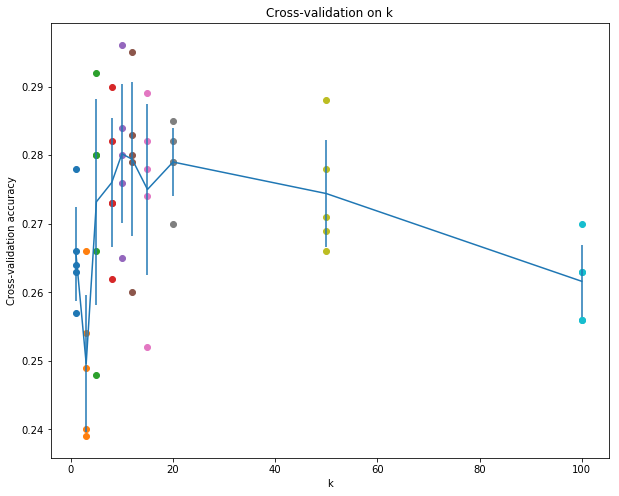

In [17]:
# plot the raw observations
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [18]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

(500L, 5000L)
[[41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 ...
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]
 [41172800. 63431149. 75888313. ... 52334313. 75718510. 29226892.]]
(500L, 5000L)
[[8.39450100e+07 1.06203359e+08 1.18660523e+08 ... 9.51065230e+07
  1.18490720e+08 7.19991020e+07]
 [1.34038391e+08 1.56296740e+08 1.68753904e+08 ... 1.45199904e+08
  1.68584101e+08 1.22092483e+08]
 [1.08356268e+08 1.30614617e+08 1.43071781e+08 ... 1.19517781e+08
  1.42901978e+08 9.64103600e+07]
 ...
 [1.17083045e+08 1.39341394e+08 1.51798558e+08 ... 1.28244558e+08
  1.51628755e+08 1.05137137e+08]
 [8.81482360e+07 1.10406585e+08 1.22863749e+08 ... 9.93097490e+07
  1.22693946e+08 7.62023280e+07]
 [1.76330797e+08 1.98589146e+08 2.11046310e+08 ... 1.87492310e+0